In [5]:
##RecuPlots and CNNs for time-series classification
##Python · MotionSense Dataset : Smartphone Sensor Data - HAR

!pip install keras.utils


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
import time
from skimage.transform import resize

from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

In [6]:
#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

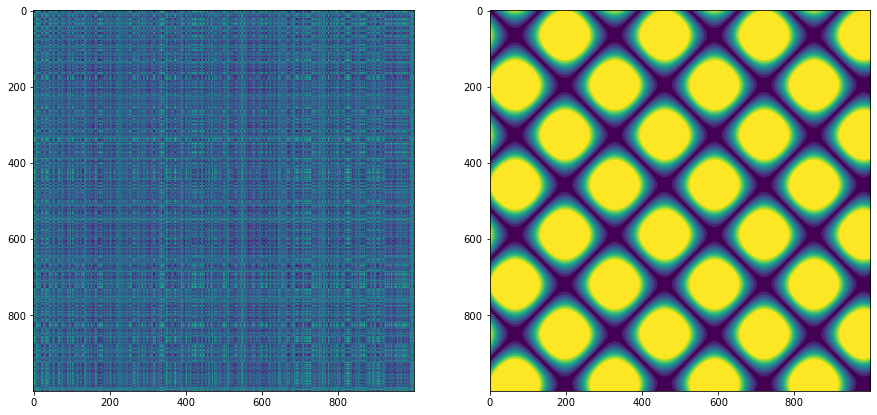

In [7]:
fig = plt.figure(figsize=(15,14))
random_series = np.random.random(1000)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(recurrence_plot(random_series[:,None]))
sinus_series = np.sin(np.linspace(0,24,1000))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(sinus_series[:,None]));

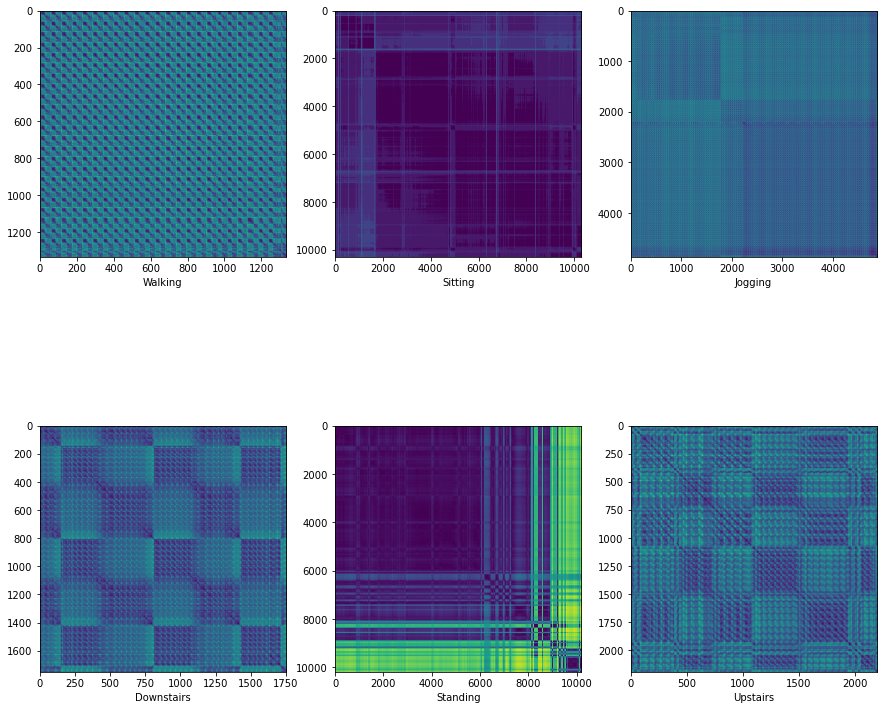

In [8]:
cols = ["attitude.roll","attitude.pitch","attitude.yaw","gravity.x","gravity.y","gravity.z","rotationRate.x","rotationRate.y","rotationRate.z","userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/wlk_15/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Walking')
ax = fig.add_subplot(2, 3, 2)
ax.imshow(recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/sit_5/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Sitting')
ax = fig.add_subplot(2, 3, 3)
ax.imshow(recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/jog_9/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Jogging')
ax = fig.add_subplot(2, 3, 4)
ax.imshow(recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Downstairs')
ax = fig.add_subplot(2, 3, 5)
ax.imshow(recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/std_6/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Standing')
ax = fig.add_subplot(2, 3, 6)
ax.imshow(recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/ups_3/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Upstairs');

In [10]:
# convert folders to class labels
# downstairs/upstairs = 0,walking/jogging  = 1, standing/sitting = 2
class_translate = {"dws_1" : 0, "dws_2" : 0, "dws_11" : 0,  \
                   "ups_3" : 0, "ups_4" : 0, "ups_12" : 0, \
                   "wlk_7" : 1, "wlk_8" : 1, "wlk_15" : 1, \
                   "jog_9" : 1, "jog_16" : 1, \
                   "std_6" : 2, "std_14" : 2, \
                   "sit_5" : 2, "sit_13": 2}

#pre allocate arrays
x_train = np.zeros((384,32,32))
y_train = np.zeros(384)
c = 0
start = time.time()
for i in class_translate.keys():    
    print("Processing set " + i)
    for j in range(1,25):
        dat = recurrence_plot(pd.read_csv("./A_DeviceMotion_data/A_DeviceMotion_data/" + i +"/" + "sub_"+ str(j) + ".csv")[cols].values, steps=100)
        dat = resize(dat, (32,32),mode='constant')
        x_train[c,:,:] = dat
        y_train[c] = class_translate[i]
        c = c + 1
end = time.time()
print('Elapsed time:')
print(end - start)

Processing set dws_1
Processing set dws_2
Processing set dws_11
Processing set ups_3
Processing set ups_4
Processing set ups_12
Processing set wlk_7
Processing set wlk_8
Processing set wlk_15
Processing set jog_9
Processing set jog_16
Processing set std_6
Processing set std_14
Processing set sit_5
Processing set sit_13
Elapsed time:
10482.815561056137


In [11]:
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro


2022-09-07 12:48:01.124891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-07 12:48:01.125233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
#reshape to include depth
X_train = x_train.reshape(x_train.shape[0], 1, 32,32)
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
# convert labels to class matrix, one-hot-encoding
Y_train = np_utils.to_categorical(y_train, 3)
# split in train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [13]:
model.fit(X_train, Y_train, epochs=200, batch_size=16,shuffle=True)

Epoch 1/200


2022-09-07 12:48:20.308063: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-07 12:48:20.687858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 3s 36ms/step - loss: 0.9764 - accuracy: 0.4406
Epoch 2/200
22/22 [==============================] - 0s 12ms/step - loss: 0.8976 - accuracy: 0.5362
Epoch 3/200
22/22 [==============================] - 0s 12ms/step - loss: 0.7472 - accuracy: 0.6203
Epoch 4/200
22/22 [==============================] - 0s 12ms/step - loss: 0.7028 - accuracy: 0.6609
Epoch 5/200
22/22 [==============================] - 0s 12ms/step - loss: 0.6467 - accuracy: 0.6870
Epoch 6/200
22/22 [==============================] - 0s 12ms/step - loss: 0.5545 - accuracy: 0.7565
Epoch 7/200
22/22 [==============================] - 0s 12ms/step - loss: 0.4867 - accuracy: 0.8000
Epoch 8/200
22/22 [==============================] - 0s 12ms/step - loss: 0.4254 - accuracy: 0.8377
Epoch 9/200
22/22 [==============================] - 0s 12ms/step - loss: 0.4995 - accuracy: 0.7710
Epoch 10/200
22/22 [==============================] - 0s 12ms/step - loss: 0.5094 - accuracy: 0.7710
Epoch 11/20

22/22 [==============================] - 0s 12ms/step - loss: 0.0696 - accuracy: 0.9797
Epoch 83/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0624 - accuracy: 0.9855
Epoch 84/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0628 - accuracy: 0.9826
Epoch 85/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0750 - accuracy: 0.9623
Epoch 86/200
22/22 [==============================] - 0s 11ms/step - loss: 0.0562 - accuracy: 0.9826
Epoch 87/200
22/22 [==============================] - 0s 12ms/step - loss: 0.1097 - accuracy: 0.9623
Epoch 88/200
22/22 [==============================] - 0s 11ms/step - loss: 0.0679 - accuracy: 0.9739
Epoch 89/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0635 - accuracy: 0.9768
Epoch 90/200
22/22 [==============================] - 0s 12ms/step - loss: 0.2036 - accuracy: 0.9362
Epoch 91/200
22/22 [==============================] - 0s 12ms/step - loss: 0.1248 - accuracy: 0.9623
Epo

22/22 [==============================] - 0s 12ms/step - loss: 0.0616 - accuracy: 0.9855
Epoch 163/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0619 - accuracy: 0.9797
Epoch 164/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0649 - accuracy: 0.9768
Epoch 165/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0495 - accuracy: 0.9884
Epoch 166/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0340 - accuracy: 0.9913
Epoch 167/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0420 - accuracy: 0.9913
Epoch 168/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0380 - accuracy: 0.9855
Epoch 169/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0504 - accuracy: 0.9797
Epoch 170/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0762 - accuracy: 0.9739
Epoch 171/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0482 - accuracy: 0

In [14]:
predictions= model.predict(x_test)
rounded = [np.argmax(x) for x in predictions]
print(K.eval(metrics.categorical_accuracy(y_test, np_utils.to_categorical(rounded, 3))))

2022-09-07 12:52:01.457200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
